In [48]:
import numpy as np 
import matplotlib.pyplot as plt

# install
## numpy
## matplotlib

## data load & preprocessing

In [49]:
from dataset.mnist import load_mnist

(train_raw_img, train_label), (test_raw_img, test_label) = load_mnist(flatten=False, normalize=False)
print(train_raw_img.shape)

(60000, 1, 28, 28)


In [50]:
# preprocessing (train & inference)

train_img = train_raw_img.reshape(len(train_raw_img.squeeze()), -1)
train_label = train_label.reshape(len(train_label), -1)

test_img = test_raw_img.reshape(len(test_raw_img.squeeze()), -1)
test_label = test_label.reshape(len(test_label), -1)

print(train_img.shape)
print(train_label.shape)
print(test_img.shape)
print(test_label.shape)

(60000, 784)
(60000, 1)
(10000, 784)
(10000, 1)


In [51]:
# normalization (set value 0 ~ 1)

train_img = train_img.astype('float')
train_img = train_img/255

test_img = test_img.astype('float')
test_img = test_img/255

## model

In [52]:
class Linear :
    def __init__(self, input_size=1, hidden_size=1) :
        self.W = np.random.randn(input_size, hidden_size)
        self.b = np.zeros(hidden_size)
        self.x = None
        self.dW = None
        self.db =  None
    
    def forward(self, x) :
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout, lr) :
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        self.W -= lr*self.dW
        self.b -= lr*self.db
        return dx

In [53]:
class Relu :
    def __init__(self) :
        self.mask = None
    
    def forward(self, x) :
        self.mask = (x < 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout) :
        dout[self.mask] = 0
        return dout                                                                                                                                                                                                                                                                                                                                                                

In [54]:
class softmax_with_crossEntropy :
    def __init__(self) :
        self.delta = 1e-7
        # softmax
        self.softmax_x = None
        self.softmax_out = None
        # crossEntropy
        self.pred = None
        self.target = None
        
    def softmax_forward(self, x) :
        self.softmax_x = x
        # subtracting the maximum value for numerical stability
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        self.softmax_out = exp_x / np.sum(exp_x, axis=-1, keepdims=True)
        return self.softmax_out

    def crossEntropy_forward(self, pred, target) :
        self.pred = pred
        self.target = target
        # avoid log(0) by adding delta
        loss = -np.sum(target * np.log(pred + self.delta))
        return loss
    
    
    def backward(self):
        batch_size = self.pred.shape[0]
        dx = (self.pred - self.target) / batch_size
        return dx

## Train

### base

In [55]:
# one_hot label 만드는 함수

def make_one_hot(labels) :
    a = []
    for label in labels :
        one_hot = np.zeros(10)
        one_hot[label] = 1
        a.append(one_hot)
    a = np.array(a)
    return a

# one_hot_labels = make_one_hot(train_label)
# print(train_label[0])
# print(one_hot_labels[0])

In [56]:
# train version 1

from collections import OrderedDict

def train_MLP(config) :
    lr, num_epoch = config['learning_rate'], config['num_epoch']
    print_loss_interval = 1
    
    layer1 = Linear(784, 100)
    relu = Relu()
    layer2 = Linear(100, 10)
    softmax_with_CE = softmax_with_crossEntropy()
    
    iter_lst = list()
    loss_lst = list()
    Non_weight_lsit = list()
    
    for iter in range(num_epoch) :
        # forward
        x = layer1.forward(train_img)
        x = relu.forward(x)
        x = layer2.forward(x)
        preds = softmax_with_CE.softmax_forward(x)
        
        # loss
        one_hot_labels = make_one_hot(train_label)
        losses = softmax_with_CE.crossEntropy_forward(preds, one_hot_labels)
        loss = losses.sum()/len(preds)
        
        if iter % print_loss_interval == 0:
            print("[epoch %d / %d] average loss : %f" % (iter, num_epoch, loss))
            
        iter_lst.append(iter)
        loss_lst.append(loss)
        
        # backward
        dL = softmax_with_CE.backward()
        Non_weight_lsit.append(np.sum(dL))
        dL = layer2.backward(dL, lr)
        dL = relu.backward(dL)
        dL = layer1.backward(dL, lr)
                     
    model = OrderedDict()
    model['layer1'] = layer1
    model['relu'] = relu
    model['layer2'] = layer2
    model['softmax_with_CE'] = softmax_with_CE
    
    return model,iter_lst, loss_lst,Non_weight_lsit

In [57]:
config = { 'learning_rate' : 0.1,
            'num_epoch' : 100
          }

model,iter_lst, loss_lst,Non_weight_lsit = train_MLP(config)

[epoch 0 / 100] average loss : 14.019757
[epoch 1 / 100] average loss : 13.296791
[epoch 2 / 100] average loss : 12.557627
[epoch 3 / 100] average loss : 11.585203
[epoch 4 / 100] average loss : 10.455917
[epoch 5 / 100] average loss : 9.761320
[epoch 6 / 100] average loss : 9.101266
[epoch 7 / 100] average loss : 8.604417
[epoch 8 / 100] average loss : 8.134574
[epoch 9 / 100] average loss : 7.736887
[epoch 10 / 100] average loss : 7.369843
[epoch 11 / 100] average loss : 7.053709
[epoch 12 / 100] average loss : 6.766511
[epoch 13 / 100] average loss : 6.514575
[epoch 14 / 100] average loss : 6.283364
[epoch 15 / 100] average loss : 6.079482
[epoch 16 / 100] average loss : 5.892703
[epoch 17 / 100] average loss : 5.724786
[epoch 18 / 100] average loss : 5.571097
[epoch 19 / 100] average loss : 5.430092
[epoch 20 / 100] average loss : 5.300274
[epoch 21 / 100] average loss : 5.179350
[epoch 22 / 100] average loss : 5.066183
[epoch 23 / 100] average loss : 4.959905
[epoch 24 / 100] aver

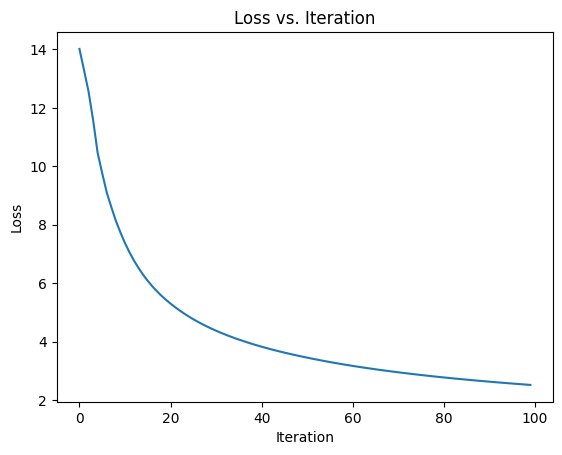

In [58]:
plt.plot(iter_lst, loss_lst)
plt.title("Loss vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [59]:
def eval(model, train_version = True) :
    if train_version :
        x = train_img
        labels = train_label.squeeze()
        print('In train dataset ... ')
    else : 
        x = test_img
        labels = test_label.squeeze()
        print('\nIn test dataset ... ')
    
    for layer in model.values() :
        if isinstance(layer, softmax_with_crossEntropy) :
            x = layer.softmax_forward(x)
        else :
            x = layer.forward(x)
            
    preds = x.argmax(axis=1)
    acc = np.sum(np.where(preds==labels, True, False))/len(labels)
    return acc

print('\t Accuracy :', eval(model, train_version=True))
print('\t Accuracy :', eval(model, train_version=False))
print()

In train dataset ... 
	 Accuracy : 0.7830666666666667

In test dataset ... 
	 Accuracy : 0.7901



### regularization

In [60]:
class Linear:
    def __init__(self, input_size=1, hidden_size=1):
        self.W = np.random.randn(input_size, hidden_size)
        self.b = np.zeros(hidden_size)
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout, lr, lambda_reg=0.01):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout) + lambda_reg * self.W
        self.db = np.sum(dout, axis=0)
        self.W -= lr * self.dW
        self.b -= lr * self.db 
        return dx


In [61]:
class MLP_Classifier :
    def __init__(self) :
        self.delta = 1e-7
        # softmax
        self.softmax_x = None
        self.softmax_out = None
        # crossEntropy
        self.pred = None
        self.target = None
        self.alpha = 0.001
        
    def softmax_forward(self, x) :
        self.softmax_x = x
        # subtracting the maximum value for numerical stability
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        self.softmax_out = exp_x / np.sum(exp_x, axis=-1, keepdims=True)
        return self.softmax_out
    
    def crossEntropy_forward(self, pred, target) :
        self.pred = pred
        self.target = target
        # avoid log(0) by adding delta
        reg_term = 0.5 * self.alpha * np.sum(pred**2)
        loss = -np.sum(target * np.log(pred + self.delta)) / len(pred) + reg_term
        return loss
    
    
    def backward(self):
        batch_size = self.pred.shape[0]
        dx = (self.pred - self.target) / batch_size
        return dx

In [62]:

# train version 1

from collections import OrderedDict

def train_MLP(config) :
    lr, num_epoch,model = config['learning_rate'], config['num_epoch'], config['model']
    print_loss_interval = 1
    
    layer1 = Linear(784, 100)
    relu = Relu()
    layer2 = Linear(100, 10)
    softmax_with_CE = model
    
    loss_lst = list()
    iter_lst = list()
    weight_list = list()
    
    for iter in range(num_epoch) :
        # forward
        x = layer1.forward(train_img)
        x = relu.forward(x)
        x = layer2.forward(x)
        preds = softmax_with_CE.softmax_forward(x)
        
        # loss
        one_hot_labels = make_one_hot(train_label)
        losses = softmax_with_CE.crossEntropy_forward(preds, one_hot_labels)
        loss = losses.sum()/len(preds)
        
        if iter % print_loss_interval == 0:
            print("[epoch %d / %d] average loss : %f" % (iter, num_epoch, loss))
        
        loss_lst.append(loss)
        iter_lst.append(iter)
        
        # backward
        dL = softmax_with_CE.backward()
        weight_list.append(np.sum(dL))
        dL = layer2.backward(dL, lr)
        dL = relu.backward(dL)
        dL = layer1.backward(dL,lr)

        
    model = OrderedDict()
    model['layer1'] = layer1
    model['relu'] = relu
    model['layer2'] = layer2
    model['softmax_with_CE'] = softmax_with_CE
    
    return model, loss_lst, iter_lst, weight_list

In [63]:
config = { 'model' : MLP_Classifier(),
            'learning_rate' : 0.1,
            'num_epoch' : 100
          }

model, loss_lst, iter_lst,weight_list = train_MLP(config)

[epoch 0 / 100] average loss : 0.000723
[epoch 1 / 100] average loss : 0.000706
[epoch 2 / 100] average loss : 0.000681
[epoch 3 / 100] average loss : 0.000672
[epoch 4 / 100] average loss : 0.000654
[epoch 5 / 100] average loss : 0.000644
[epoch 6 / 100] average loss : 0.000633
[epoch 7 / 100] average loss : 0.000624
[epoch 8 / 100] average loss : 0.000615
[epoch 9 / 100] average loss : 0.000608
[epoch 10 / 100] average loss : 0.000601
[epoch 11 / 100] average loss : 0.000596
[epoch 12 / 100] average loss : 0.000591
[epoch 13 / 100] average loss : 0.000586
[epoch 14 / 100] average loss : 0.000583
[epoch 15 / 100] average loss : 0.000579
[epoch 16 / 100] average loss : 0.000576
[epoch 17 / 100] average loss : 0.000574
[epoch 18 / 100] average loss : 0.000571
[epoch 19 / 100] average loss : 0.000569
[epoch 20 / 100] average loss : 0.000567
[epoch 21 / 100] average loss : 0.000564
[epoch 22 / 100] average loss : 0.000563
[epoch 23 / 100] average loss : 0.000561
[epoch 24 / 100] average l

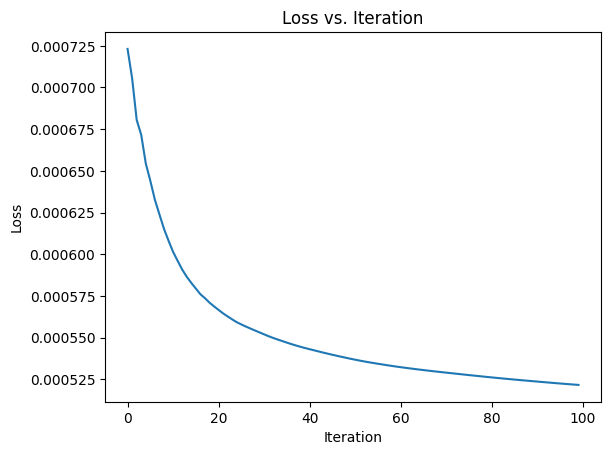

In [64]:
plt.plot(iter_lst, loss_lst)
plt.title("Loss vs. Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

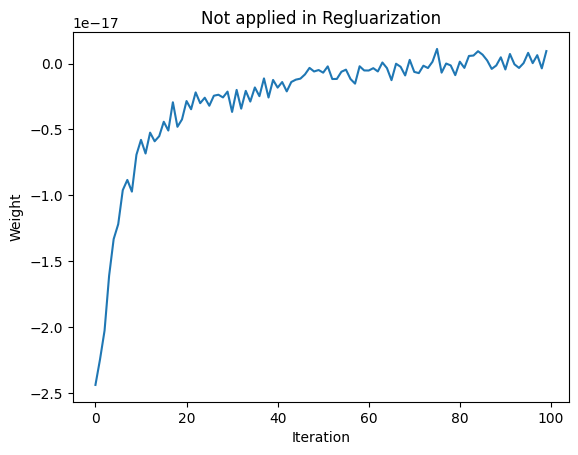

In [71]:
plt.plot(Non_weight_lsit)
plt.title("Not applied in Regluarization")
plt.xlabel("Iteration")
plt.ylabel("Weight")
plt.show()

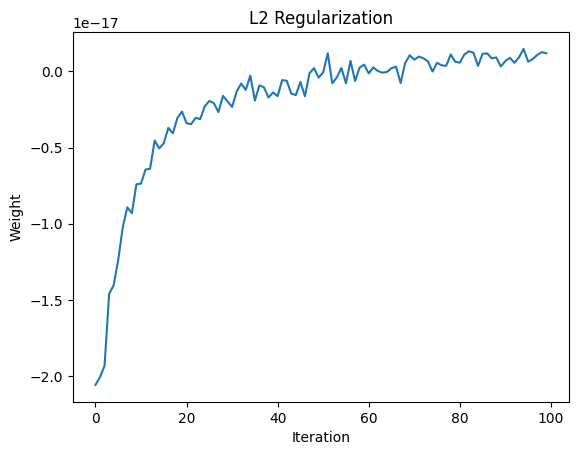

In [72]:
plt.plot(weight_list)
plt.title("L2 Regularization")
plt.xlabel("Iteration")
plt.ylabel("Weight")
plt.show()

In [66]:
def eval(model, train_version = True) :
    if train_version :
        x = train_img
        labels = train_label.squeeze()
        print('In train dataset ... ')
    else : 
        x = test_img
        labels = test_label.squeeze()
        print('\nIn test dataset ... ')
    
    for layer in model.values() :
        if isinstance(layer, MLP_Classifier) :
            x = layer.softmax_forward(x)
        else :
            x = layer.forward(x)
            
    preds = x.argmax(axis=1)
    acc = np.sum(np.where(preds==labels, True, False))/len(labels)
    return acc

print('\t Accuracy :', eval(model, train_version=True))
print('\t Accuracy :', eval(model, train_version=False))
print()

In train dataset ... 
	 Accuracy : 0.7913

In test dataset ... 
	 Accuracy : 0.8006

